In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data cleaning and feature engineering


In [33]:
data = pd.read_csv("customers.csv")

In [34]:
data['TotalCharges'] = data['TotalCharges'].replace(" ", np.nan).astype('float32') # Force empty values to be "Nan"

In [35]:
data = data[data["TotalCharges"].notnull()]  #let's drop the "Nan values, since they will drive down our sample mean
data = data.reset_index()[data.columns] #and let's reindex... just in case we want to loop the dataframe.

In [36]:
#Index is already a good ID for clients
data.drop(columns='customerID',inplace=True)

In [37]:
data['MonthlyExpense'] = data['TotalCharges']/data['tenure']

In [41]:
# 1 if male, 0 otherwise
data['gender'] = (data['gender']=='Male')*1

# 1 if internet, 0 otherwise
data['Internet'] = (~(data['InternetService'] == 'No'))*1
# 1 if fiber, 0 if DSL
data['Fiber'] = (data['InternetService'] == 'Fiber optic')*1

# Now can drop 'InternetService' feature because same information
data.drop(columns='InternetService', inplace=True)

# 0 -> month to month
# 1 -> 1 year
# 2 -> 2 year
data['Contract'] = pd.factorize(data['Contract'])[0]

# Electronic check          -> 0
# Mailed check              -> 1
# Bank transfer (automatic) -> 2
# Credit card (automatic)   -> 3
data['PaymentMethod'] = pd.factorize(data['PaymentMethod'])[0]

# Deal with the rest of categorical variable
# Yes -> 1
# No  -> 0
for column in data.select_dtypes(include=np.object).columns:
    data[column] = (data[column]=='Yes')*1


In [42]:
data.dtypes

gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float32
Churn                 int64
MonthlyExpense      float64
Internet              int64
Fiber                 int64
dtype: object

# PCA to eliminate residual colinearity

In [43]:
from sklearn.decomposition import PCA

In [44]:
pca = PCA()
pca.fit(data.drop(columns="Churn"))
Principal_Components = pca.transform(data.drop(columns="Churn"))

In [58]:
sum(Principal_Components[:,-1] == np.zeros(Principal_Components.shape[0]))

7032

Apparently last principal component is only zeros so we drop it

In [59]:
Principal_Components = pd.DataFrame(Principal_Components)

In [61]:
Principal_Components.drop(columns = 20, inplace=True)

# Regression

In [171]:
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [185]:
def CrossValidation(method,metric,X,y,lambdas, method_name):
    Cs = 1/lambdas
    train_scores, test_scores = validation_curve(method, X, y, param_name="C", param_range=Cs,
                                             scoring=metric, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    ###### plot #####
    plt.figure(figsize=(12,10))
    plt.semilogx(lambdas, train_scores_mean, label="Training "+metric+" score")
    plt.semilogx(lambdas, test_scores_mean, label="Test "+metric+" score")
    plt.title("Cross validation of the L2 regularization hyperparameter $\lambda$ for the "+method_name)
    plt.xlabel(r"$\lambda$")
    plt.ylabel(metric+" score")
    plt.legend(loc="best")
    plt.show()
    
    
    

In [ ]:
X = Principal_Components.values
y = data['Churn'].values

In [178]:
lambdas = np.logspace(-3, 3, 7)
metric = 'accuracy'

In [186]:
metrics = ['accuracy', 'recall', 'f1']

In [182]:
method1 = LogisticRegression(penalty='l2',random_state = 0, solver='lbfgs',max_iter=1000)
method2 = SVC(gamma='scale')

In [183]:
methods = [method1,method2]
method_names = ['Logistic regression', 'Support vector classification']

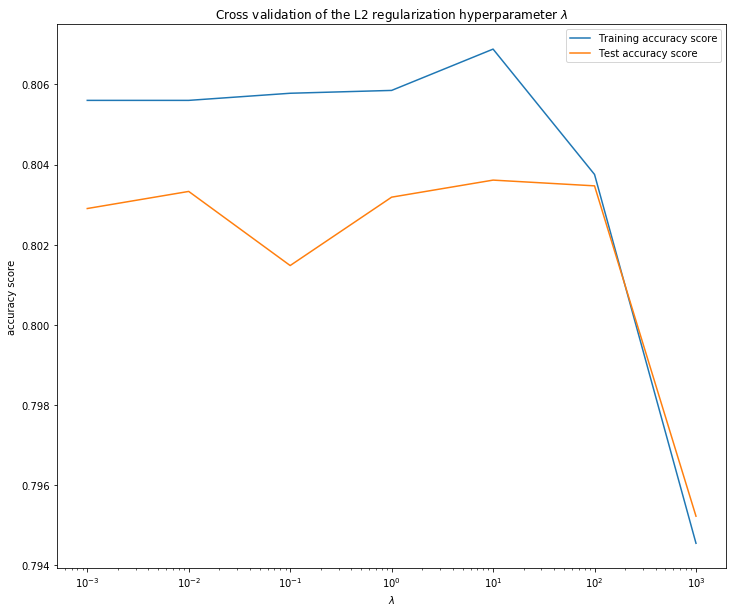

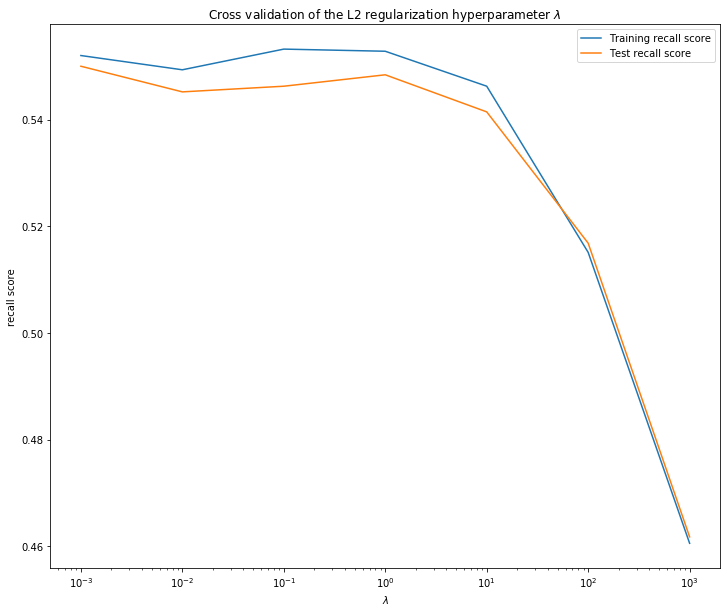

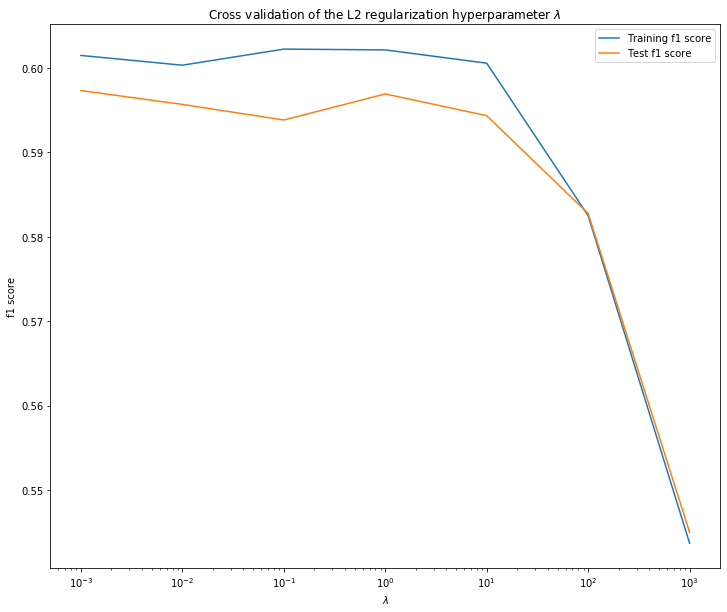

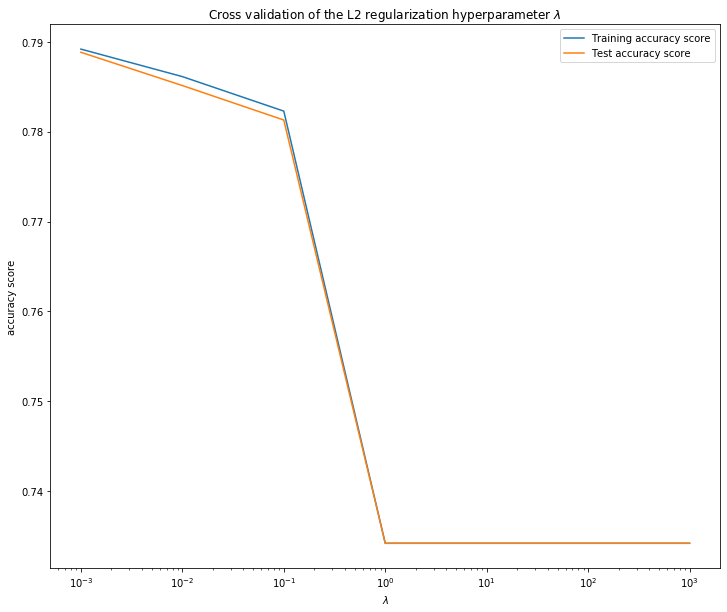

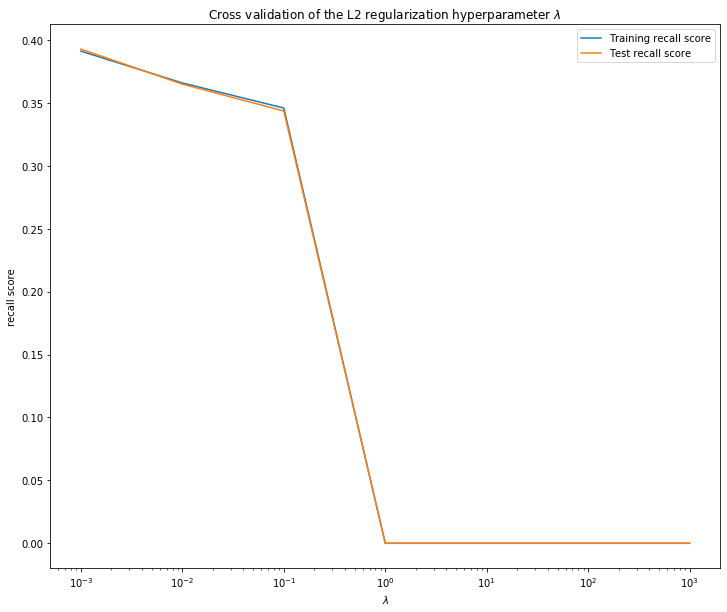

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.7/site-packages/skle

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.7/site-packages/skle

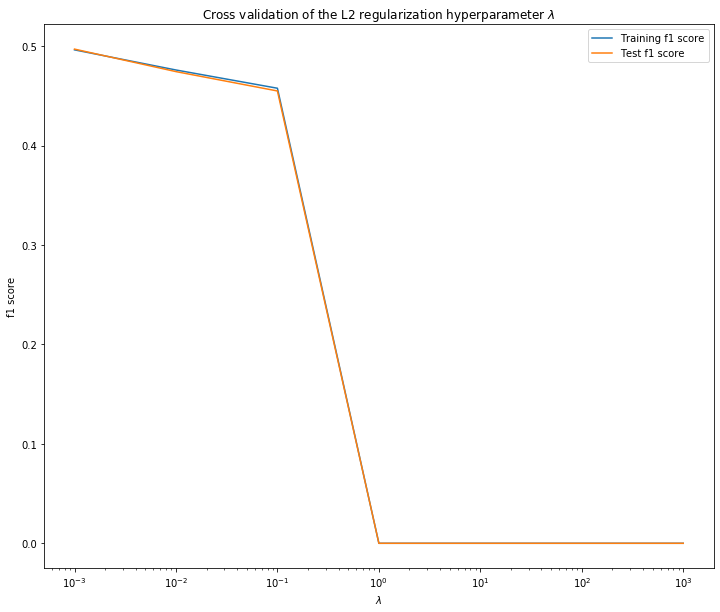

In [187]:
for i,method in enumerate(methods):
    method_name = method_names[i]
    for metric in metrics:
        CrossValidation(method,metric,X,y,lambdas)